In [1]:
%load_ext autoreload
%autoreload 2

import jax  # noqa: I001
jax.config.update("jax_enable_x64", True)

import numpyro  # noqa: E402, I001
numpyro.set_host_device_count(4)

import numpy as np  # noqa: E402, I001

## Fit the Data

In [17]:
import pprint

from des_y6_imsim_analysis import interpolant
from des_y6_imsim_analysis.stats import compute_model_chi2_info, measure_map, run_mcmc
from des_y6_imsim_analysis.utils import (
    measure_m_dz,
    plot_results_delta_nz,
    plot_results_fg_model,
    plot_results_nz,
    read_data_one_tomo_bin,
)


def _measure_m_dz(fname, kwargs):
    print("======================================================")
    print(fname)
    print("======================================================")
    model_module = interpolant

    data = read_data_one_tomo_bin(fname)

    model_data = model_module.make_model_data(
        z=data.z,
        nzs=data.nzs,
        mn=data.mn,
        cov=data.cov,
        mn_pars=data.mn_pars,
        zbins=data.zbins,
        **kwargs,
    )

    map_params = measure_map(
        model_module=model_module,
        model_data=model_data,
        seed=254,
        progress_bar=True,
        num_steps=50_000,
        learning_rate=1e-2,
    )

    chi2_info = compute_model_chi2_info(
        model_module=model_module,
        model_data=model_data,
        data=data,
        params=map_params,
    )

    print("chi2:", chi2_info['chi2'])
    print("dof:", chi2_info['dof'])
    print("p-value:", chi2_info['p_value'])
    print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
        (chi2_info['model_mn'][:data.nzs.shape[0]] - 1).tolist(),
        (data.mn[:data.nzs.shape[0]] - 1).tolist(),
        (np.sqrt(np.diag(data.cov)[:data.nzs.shape[0]])).tolist(),
    ))
    print("map params:\n", pprint.pformat(map_params))

    mcmc = run_mcmc(
        model_module=model_module,
        model_data=model_data,
        init_params=map_params,
        seed=231,
        progress_bar=True,
        dense_mass=True,
        num_samples=2000,
    )

    mcmc.print_summary(exclude_deterministic=False)
    samples = mcmc.get_samples()

    # plot_results_nz(model_module=model_module, model_data=model_data, samples=samples)
    # plot_results_delta_nz(model_module=model_module, model_data=model_data, samples=samples)
    # plot_results_fg_model(model_module=model_module, model_data=model_data, samples=samples)

    mdz = measure_m_dz(
        model_module=model_module,
        model_data=model_data,
        samples=samples,
        return_dict=True,
        shift_negative=True,
    )

    m_mn = [np.mean(mdz[f"m_b{i}"]) for i in range(4)]
    m_sd = [np.std(mdz[f"m_b{i}"]) for i in range(4)]

    dz_mn = [np.mean(mdz[f"dz_b{i}"]) for i in range(4)]
    dz_sd = [np.std(mdz[f"dz_b{i}"]) for i in range(4)]

    print("|--------------------------------------------|")
    print("| bin | m [10^-3, 3sigma] | dz               |")
    print("|--------------------------------------------|")
    for i in range(data.nzs.shape[0]):
        print(
            "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
                i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
            )
        )
    print("|--------------------------------------------|")
    print("======================================================")
    print("======================================================\n\n")

    return [dz_mn[0], dz_sd[0], m_mn[0], m_sd[0]]


In [18]:
fnames = [
    "../../data/N_gamma_alpha_v3_statistical_i_22.5_23.0.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_23.0_23.5.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_23.5_24.0.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_24.0_24.5.hdf5",
]

kwargs = {
    "num_pts": 10,
    "model_kind": "g",
}
# kwargs = {
#     "num_pts": 9,
#     "model_kind": "F",
#     "fixed_param_values": {
#         "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0,
#     },
# }

mags = np.array([22.75, 23.25, 23.75, 24.25])
dz_mn_sd = []

for fname in fnames:
    dz_mn_sd.append(_measure_m_dz(fname, kwargs))

dz_mn_sd = np.array(dz_mn_sd)

../../data/N_gamma_alpha_v3_statistical_i_22.5_23.0.hdf5


100%|██████████| 50000/50000 [00:10<00:00, 4719.49it/s, init loss: 291792.1445, avg. loss [47501-50000]: -60.1428]


chi2: 0.19884022457578843
dof: 1
p-value: 0.6556586163492004
m vals:
    model: [0.01683192690240376]
    data: [0.01574325548099731]
     err: [0.005123939272084106]
map params:
 {'a0_b0': Array(0.49528305, dtype=float64),
 'a1_b0': Array(0.51474722, dtype=float64),
 'a2_b0': Array(0.51365834, dtype=float64),
 'a3_b0': Array(0.49128266, dtype=float64),
 'a4_b0': Array(0.49764196, dtype=float64),
 'a5_b0': Array(0.49726277, dtype=float64),
 'a6_b0': Array(0.50080623, dtype=float64),
 'a7_b0': Array(0.50096326, dtype=float64),
 'a8_b0': Array(0.50085183, dtype=float64),
 'a9_b0': Array(0.50023297, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.50      0.00      0.50      0.49      0.50   7599.69      1.00
     a1_b0      0.51      0.00      0.51      0.51      0.52   7698.72      1.00
     a2_b0      0.51      0.00      0.51      0.51      0.52   7170.11      1.00
     a3_b0      0.49      0.00      0.49      0.49      0.50   8425.03      1.00
     a4_b0      0.50      0.00      0.50      0.49      0.50   9131.12      1.00
     a5_b0      0.50      0.00      0.50      0.50      0.50   9628.33      1.00
     a6_b0      0.50      0.00      0.50      0.50      0.50  10933.39      1.00
     a7_b0      0.50      0.00      0.50      0.50      0.50  11424.17      1.00
     a8_b0      0.50      0.00      0.50      0.50      0.50  11022.99      1.00
     a9_b0      0.50      0.00      0.50      0.50      0.50   8604.83      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4714.14it/s, init loss: 132610.8329, avg. loss [47501-50000]: -55.4741]


chi2: 3.219031342498056
dof: 1
p-value: 0.07278669021549493
m vals:
    model: [-0.004279467671882808]
    data: [-0.0028866096121270557]
     err: [0.006324402750695496]
map params:
 {'a0_b0': Array(0.49263386, dtype=float64),
 'a1_b0': Array(0.5206164, dtype=float64),
 'a2_b0': Array(0.49482639, dtype=float64),
 'a3_b0': Array(0.51013472, dtype=float64),
 'a4_b0': Array(0.48978619, dtype=float64),
 'a5_b0': Array(0.49580626, dtype=float64),
 'a6_b0': Array(0.49497044, dtype=float64),
 'a7_b0': Array(0.49850592, dtype=float64),
 'a8_b0': Array(0.49943938, dtype=float64),
 'a9_b0': Array(0.49906174, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.49      0.00      0.49      0.49      0.50   7916.36      1.00
     a1_b0      0.52      0.00      0.52      0.51      0.53   7693.23      1.00
     a2_b0      0.49      0.00      0.49      0.49      0.50   6815.69      1.00
     a3_b0      0.51      0.00      0.51      0.50      0.52   7756.38      1.00
     a4_b0      0.49      0.00      0.49      0.49      0.49   7033.43      1.00
     a5_b0      0.50      0.00      0.50      0.49      0.50   9994.32      1.00
     a6_b0      0.49      0.00      0.49      0.49      0.50  11379.33      1.00
     a7_b0      0.50      0.00      0.50      0.50      0.50  10969.95      1.00
     a8_b0      0.50      0.00      0.50      0.50      0.50  11631.21      1.00
     a9_b0      0.50      0.00      0.50      0.50      0.50   9429.45      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4699.55it/s, init loss: 46158.8501, avg. loss [47501-50000]: -51.4488]


chi2: 1.171408854366039
dof: 1
p-value: 0.27911194789539956
m vals:
    model: [0.0045950169292099385]
    data: [0.0035297552989796976]
     err: [0.009518229252611372]
map params:
 {'a0_b0': Array(0.4901382, dtype=float64),
 'a1_b0': Array(0.51436086, dtype=float64),
 'a2_b0': Array(0.51272232, dtype=float64),
 'a3_b0': Array(0.52282795, dtype=float64),
 'a4_b0': Array(0.49020086, dtype=float64),
 'a5_b0': Array(0.49071095, dtype=float64),
 'a6_b0': Array(0.4940566, dtype=float64),
 'a7_b0': Array(0.49466859, dtype=float64),
 'a8_b0': Array(0.49514554, dtype=float64),
 'a9_b0': Array(0.49806272, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.49      0.00      0.49      0.48      0.50  11807.25      1.00
     a1_b0      0.51      0.01      0.51      0.51      0.52  12064.50      1.00
     a2_b0      0.51      0.01      0.51      0.50      0.52  12514.78      1.00
     a3_b0      0.52      0.01      0.52      0.51      0.53  14921.62      1.00
     a4_b0      0.49      0.01      0.49      0.48      0.50  13168.13      1.00
     a5_b0      0.49      0.00      0.49      0.48      0.50  14607.96      1.00
     a6_b0      0.49      0.00      0.49      0.49      0.50  14915.28      1.00
     a7_b0      0.49      0.00      0.49      0.49      0.50  15486.26      1.00
     a8_b0      0.50      0.00      0.50      0.49      0.50  15238.32      1.00
     a9_b0      0.50      0.00      0.50      0.50      0.50  10508.48      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4722.11it/s, init loss: 5414.8409, avg. loss [47501-50000]: -40.5035]


chi2: 2.6621882546760545
dof: 1
p-value: 0.10275927615551236
m vals:
    model: [0.00028908272078864705]
    data: [-0.001423520082866614]
     err: [0.02328194786250383]
map params:
 {'a0_b0': Array(0.48976389, dtype=float64),
 'a1_b0': Array(0.53109755, dtype=float64),
 'a2_b0': Array(0.50138361, dtype=float64),
 'a3_b0': Array(0.5087787, dtype=float64),
 'a4_b0': Array(0.49836924, dtype=float64),
 'a5_b0': Array(0.50331739, dtype=float64),
 'a6_b0': Array(0.48047167, dtype=float64),
 'a7_b0': Array(0.49428499, dtype=float64),
 'a8_b0': Array(0.50191053, dtype=float64),
 'a9_b0': Array(0.49535805, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.49      0.01      0.49      0.47      0.51  14671.89      1.00
     a1_b0      0.53      0.01      0.53      0.51      0.55  15094.04      1.00
     a2_b0      0.50      0.01      0.50      0.48      0.52  16498.86      1.00
     a3_b0      0.51      0.01      0.51      0.49      0.53  16198.28      1.00
     a4_b0      0.50      0.01      0.50      0.48      0.52  15024.44      1.00
     a5_b0      0.50      0.01      0.50      0.49      0.52  16206.26      1.00
     a6_b0      0.48      0.01      0.48      0.47      0.49  15691.32      1.00
     a7_b0      0.49      0.01      0.49      0.48      0.50  18078.76      1.00
     a8_b0      0.50      0.01      0.50      0.49      0.51  14312.15      1.00
     a9_b0      0.50      0.00      0.50      0.49      0.50  14814.85      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

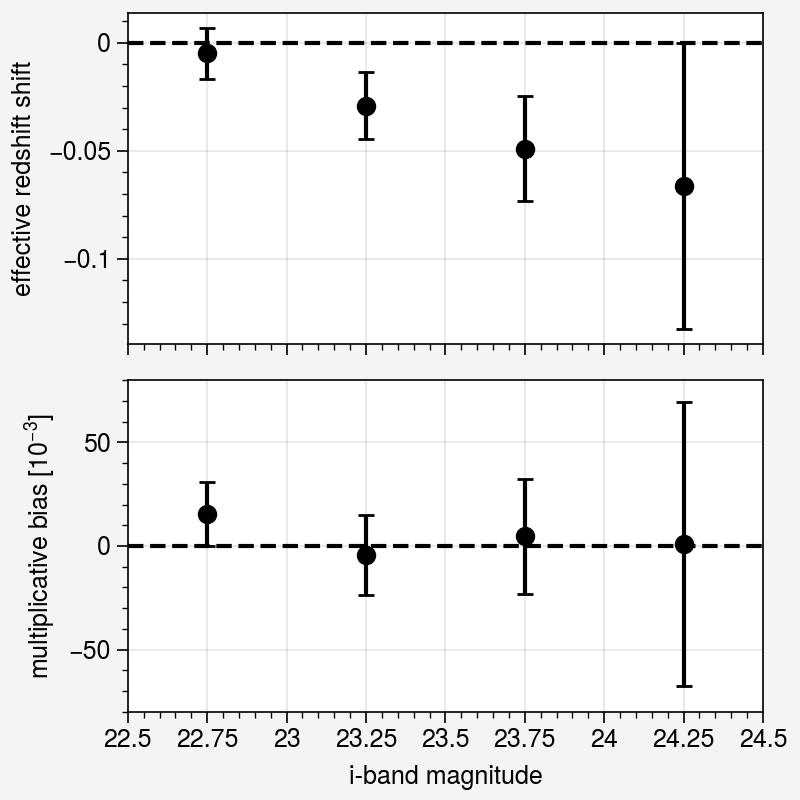

In [26]:
import ultraplot as uplt


fig, axs = uplt.subplots(figsize=(4, 4), nrows=2, ncols=1, sharey=0)

ax = axs[0, 0]
ax.errorbar(
    mags, dz_mn_sd[:, 0], fmt="ko", yerr=dz_mn_sd[:, 1] * 3
)
ax.axhline(0, color="k", linestyle="dashed")
ax.format(
    xlabel="i-band magnitude",
    ylabel="effective redshift shift",
    xlim=(22.5, 24.5),
)

ax = axs[1, 0]
ax.errorbar(
    mags, dz_mn_sd[:, 2] / 1e-3, fmt="ko", yerr=dz_mn_sd[:, 3] / 1e-3 * 3
)
ax.axhline(0, color="k", linestyle="dashed")
ax.format(
    xlabel="i-band magnitude",
    ylabel="multiplicative bias [$10^{-3}$]",
    xlim=(22.5, 24.5),
    ylim=(-80, 80),
)